In [ ]:
import tensorflow as tf
import os
import pathlib

DATASET_PATH = 'data/mini_speech_commands'

data_dir = pathlib.Path(DATASET_PATH)
if not data_dir.exists():
  tf.keras.utils.get_file(
      'mini_speech_commands.zip',
      origin="http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip",
      extract=True,
      cache_dir='.', cache_subdir='data')
#test_file = tf.io.read_file(DATASET_PATH+'/down/0a9f9af7_nohash_0.wav')

  
def audio_to_mfcc(audio_contents, channels=1, sample_rate=16000, dct_counts=20, debug=False):
    waveform, sample_rate = tf.audio.decode_wav(contents=audio_contents,
                                                desired_channels=channels,
                                                desired_samples=sample_rate)
    waveform = tf.squeeze(waveform, axis=-1)
    input_len = 16000
    if tf.shape(waveform) > input_len:
        waveform = waveform[: input_len]  # in this dataset, the max samples of waveform is 16000
    elif tf.shape(waveform) < input_len:
        zero_padding = tf.zeros(shape=[16000] - tf.shape(waveform), dtype=tf.float32)
        waveform = tf.cast(waveform, dtype=tf.float32)  # make sure waveform has the same type as zero padding
        waveform = tf.concat([waveform, zero_padding], axis=0)  # waveform with zero padding
    stft = tf.signal.stft(signals=waveform, frame_length=640, frame_step=640, fft_length=1024)
    spectrogram = tf.abs(stft)
    spectrogram = tf.square(spectrogram)
    # Warp the linear scale spectrogram into the mel-scale
    num_spectrogram_bins = stft.shape.as_list()[-1]
    lower_edge_hertz, upper_edge_hertz, num_mel_bins = 80, tf.cast(x=sample_rate / 2, dtype=tf.float32), 128
    linear_to_mel_weight_matrix = tf.signal.linear_to_mel_weight_matrix(num_mel_bins=num_mel_bins,
                                                                        num_spectrogram_bins=num_spectrogram_bins,
                                                                        sample_rate=sample_rate,
                                                                        lower_edge_hertz=lower_edge_hertz,
                                                                        upper_edge_hertz=upper_edge_hertz)
    spectrogram = tf.sqrt(spectrogram)
    mel_spectrogram = tf.tensordot(spectrogram, linear_to_mel_weight_matrix, 1)
    mel_spectrogram.set_shape(spectrogram.shape[:-1].concatenate(linear_to_mel_weight_matrix.shape[-1:]))
    # Compute a stabilized log to get log-magnitude mel-scale spectrogram
    log_mel_spectrogram = tf.math.log(mel_spectrogram + 1e-6)
    # Compute MFCCs from log_mel_spectrogram
    mfcc = tf.signal.mfccs_from_log_mel_spectrograms(log_mel_spectrogram)
    if debug:
        print('waveform shape:            ', waveform.shape)
        print('stft shape:                ', stft.shape)
        print('spectrogram shape:         ', spectrogram.shape)
        print('mel_spectrogram shape:     ', mel_spectrogram.shape)
        print('log_mel_spectrogram shape: ', log_mel_spectrogram.shape)
        print('mfcc shape:                ', mfcc.shape)
        print('sample_rate:               ', sample_rate)
        print('num_spectrogram_bins:      ', num_spectrogram_bins)
        print('num_mel_bins:              ', num_mel_bins)
        print('lower_edge_hertz:          ', lower_edge_hertz)
        print('upper_edge_hertz:          ', upper_edge_hertz)
    
    mfcc = mfcc[..., :dct_counts]
    return mfcc, mel_spectrogram


if __name__ == '__main__':
  
    input_file = tf.constant(DATASET_PATH+'/down/0a9f9af7_nohash_0.wav')

    # Compute the mfcc
    audio = tf.io.read_file(input_file)
    mfcc, mel_spectrogram = audio_to_mfcc(audio, debug=True)

    # Get only the first 20
    print(mfcc.shape)
    

waveform shape:             (16000,)
stft shape:                 (25, 513)
spectrogram shape:          (25, 513)
mel_spectrogram shape:      (25, 128)
log_mel_spectrogram shape:  (25, 128)
mfcc shape:                 (25, 128)
sample_rate:                tf.Tensor(16000, shape=(), dtype=int32)
num_spectrogram_bins:       513
num_mel_bins:               128
lower_edge_hertz:           80
upper_edge_hertz:           tf.Tensor(8000.0, shape=(), dtype=float32)
(25, 20)


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
%matplotlib inline

Plotting Spectrogram V1

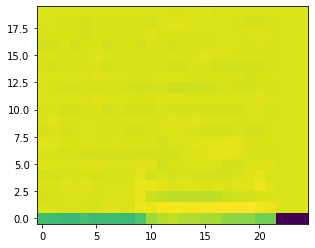

In [ ]:
fig, ax = plt.subplots()
mfcc = np.swapaxes(mfcc, 0, 1)
cax = ax.imshow(mfcc, interpolation = 'nearest', cmap = 'viridis', origin = 'lower')
plt.show()

Plotting Spectrogram V2

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Only one segment is calculated since parameter NFFT (=256) >= signal length (=25).
  """Entry point for launching an IPython kernel.


Text(0, 0.5, 'Frequency')

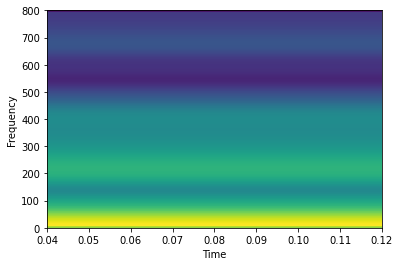

In [ ]:
powerSpectrum, frequenciesFound, time, imageAxis = plt.specgram(mel_spectrogram, Fs = 1600)
plt.xlabel('Time')
plt.ylabel('Frequency')

Plotting Spectrogram V3

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Only one segment is calculated since parameter NFFT (=256) >= signal length (=20).
  """Entry point for launching an IPython kernel.


Text(0, 0.5, 'Frequency')

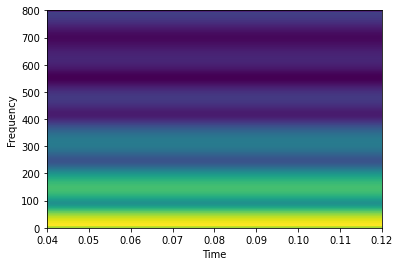

In [ ]:
powerSpectrum, frequenciesFound, time, imageAxis = plt.specgram(mfcc, Fs = 1600)
plt.xlabel('Time')
plt.ylabel('Frequency')